In [10]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax
import jax.numpy as jnp

from tools import BlindColours, zero_balanced_weights

In [11]:
bc = BlindColours()
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()

In [12]:
def logs(params, X, Y, out_dim):
    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    w2w1 = w2 @ w1
    w1w1 = w1.T @ w1
    w2w2 = w2 @ w2.T
    return w2w1, w1w1, w2w2

logs = jax.jit(logs)

In [13]:
np.random.seed(1)

in_dim = 8
hidden_dim = 14
out_dim = 8

learning_rate = 0.05
training_steps = 2000

training_data, _, _ = gs.datasets.Hierarchy(False, True)

network_functions = []
w1w1s = []
w2w2s = []
lossess = []

for i, (w1_init, w2_init) in enumerate([(gs.init.Normal(0., 0.0001), gs.init.Normal(0., 0.0001)),
                                        (gs.init.Normal(0., .42), gs.init.Normal(0., .42)),
                                        zero_balanced_weights(in_dim, hidden_dim, out_dim, .44)]):
    
    if i == 2:
        w1_init, w2_init = gs.init.FromFixedValue(w1_init), gs.init.FromFixedValue(w2_init)

    network_function = []
    w1w1 = []
    w2w2 = []
    losses = []

    X, Y = training_data(None)

    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss_fnct = gs.MeanSquaredError()

    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=w1_init),
        gs.Linear(out_dim, bias=False, weight_init=w2_init)
    ])

    trainer = gs.Trainer(task, mlp, loss_fnct, optimiser)
    state, params = gs.assemble(1)
    
    w1 = params["network"]["layer-0"]["w"][0]
    w2 = params["network"]["layer-1"]["w"][0]
    network_function.append(w2 @ w1)
    w1w1.append(w1.T @ w1)
    w2w2.append(w2 @ w2.T)

    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        w2w1_, w1w1_, w2w2_ = logs(params, X, Y, out_dim)
        network_function.append(w2w1_)
        w1w1.append(w1w1_)
        w2w2.append(w2w2_)
        losses.append(1./8. * loss)
    
    network_functions.append(network_function)
    w1w1s.append(w1w1)
    w2w2s.append(w2w2)
    lossess.append(losses)

In [14]:
def arange_svd(Y, u, vt):
    sort = np.sign(np.abs(np.round(Y.T @ vt.T)))
    idxs = np.where(sort == 1)[1]
    u = u @ sort.T
    sgn = np.diag(np.sign(np.sum(u, axis=0)))
    u = sgn.T @ u
    vt = sort @ vt
    vt = sgn @ vt
    return u, vt

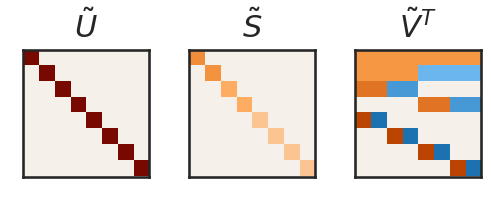

In [15]:
sigma_yx = 1./8. * Y.T @ X
U, S, VT = np.linalg.svd(sigma_yx, False)
U, VT = arange_svd(Y, U, VT)

max_val = np.max([U, np.diag(S), VT]) * 1.05

fig, axs = plt.subplots(1, 3, figsize=(5.25, 2.5))
axs[0].imshow(U, cmap=div_cmap, vmin=-max_val, vmax=max_val)
axs[1].imshow(np.diag(S), cmap=div_cmap, vmin=-max_val, vmax=max_val)
axs[2].imshow(VT, cmap=div_cmap, vmin=-max_val, vmax=max_val)
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
axs[0].set_title("$\\tilde{U}$", pad=9., fontsize=22)
axs[1].set_title("$\\tilde{S}$", pad=9., fontsize=22)
axs[2].set_title("$\\tilde{V}^T$", pad=9., fontsize=22)

fig.tight_layout()
fig.savefig("./figures/figure-3_b-top.svg")

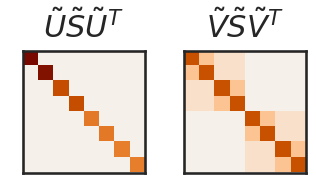

In [16]:
sigma_yx = 1./8. * Y.T @ X
U, S, VT = np.linalg.svd(sigma_yx, False)

max_val = np.max([np.max(U@np.diag(S)@U.T), np.max(VT.T@np.diag(S)@VT)]) * 1.05

fig, axs = plt.subplots(1, 2, figsize=(3.5, 2.5))
axs[0].imshow(U@np.diag(S)@U.T, cmap=div_cmap, vmin=-max_val, vmax=max_val)
axs[1].imshow(VT.T@np.diag(S)@VT, cmap=div_cmap, vmin=-max_val, vmax=max_val)
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
axs[0].set_title("$\\tilde{U}\\tilde{S}\\tilde{U}^T$", pad=9., fontsize=22)
axs[1].set_title("$\\tilde{V}\\tilde{S}\\tilde{V}^T$", pad=9., fontsize=22)

fig.tight_layout()
fig.savefig("./figures/figure-3_b-bottom.svg")

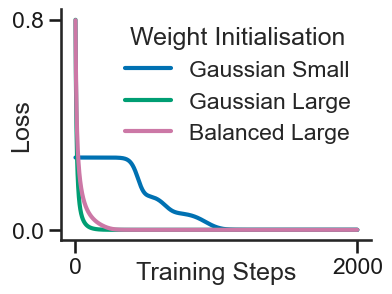

In [17]:
labels = ["Gaussian Small", "Gaussian Large", "Balanced Large"]
colours = [blind_colours[1], blind_colours[2], blind_colours[3]]
fig, ax = plt.subplots(figsize=(4., 3.))
for i, loss in enumerate(lossess):
    ax.plot(loss, lw=3., color=colours[i], label=labels[i])
ax.legend(loc=(.175, 0.38), title="Weight Initialisation", frameon=False)
ax.set_xlabel("Training Steps", labelpad=-12)
ax.set_ylabel("Loss", labelpad=-15)
ax.set_xticks([0, 2000])
ax.set_yticks([0, 0.8])
sns.despine()
fig.savefig("./figures/figure-3_f.svg")

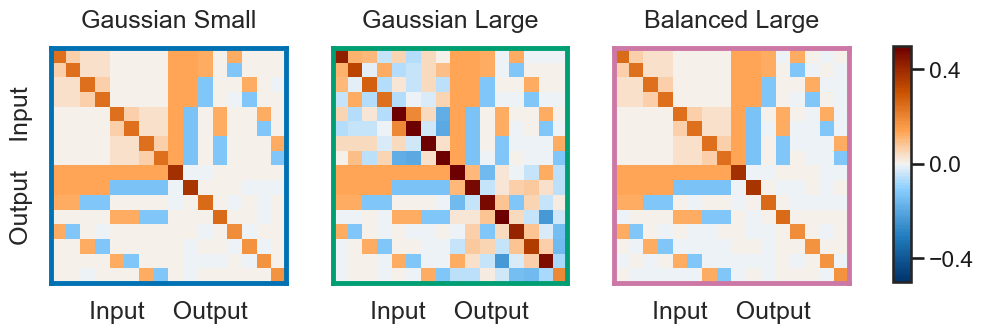

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3.5), sharex=True, sharey=True)
for i, label in enumerate(labels):
    qqt = np.vstack([
        np.hstack([w1w1s[i][-1], network_functions[i][-1].T]),
        np.hstack([network_functions[i][-1], w2w2s[i][-1]])
    ])
    vals = axs[i].matshow(1./8. * qqt, cmap=div_cmap, vmin=-1./8. * 4, vmax=1./8. * 4)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(label, pad=15.)

for ax in axs:
    ax.set_xlabel("Input    Output")
axs[0].set_ylabel("Output    Input")
    
for ax, c in zip(axs, colours):
    for spine in ax.spines.values():
        spine.set_edgecolor(c)
        spine.set_linewidth(3.5)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.89, 0.1625, 0.017, 0.675])
cbar = fig.colorbar(vals, cax=cbar_ax)
cbar.ax.set_yticks([-0.4, 0., 0.4])
fig.savefig("./figures/figure-3_c-d-e.svg")

In [ ]:
#TODO: be able to look at the quadrants
#plot something with the rate. just try it ot see if the rate is the same